Проект ведётся в соответствии со стандартом [CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining)

# Анализ требований (Business Understanding)

**Бизнес-цель**: разработать модель, которая позволила бы агенству недвижимости обойти конкурентов по скорости и качеству совершения сделок.

**Data-Science цель**: разработать регрессионную модель прогнозирования стоимости жилья для агенства недвижимости, взяв за основу имеющийся [датасет](https://drive.google.com/file/d/11-ZNNIdcQ7TbT8Y0nsQ3Q0eiYQP__NIW/view?usp=share_link)
*(датасет также синхронизируется средствами DVC на google drive)*.

На этапе фактического внедрения модели необходимо прибегнуть к A/B-тестированию, сопоставив скорость и качество совершения сделок до внедрения модели и после интеграции модели прогнозирования стоимости жилья.
При этом уже сейчас можно было бы уточнить у заказчика, что он понимает под качеством совершения сделок, какие показатели у агенства сейчас и с какими конкурентами предполагается вести сравнение.

Ввиду отсутсвия на данный момент этой информации, можно предположить, что агенство недвижимости хочет максимизировать среднее отношение стоимости сделки $\text{Value}_\text{trans}$ ко времени совершения этой сделки $t_\text{trans}$ (*trans* от англ. *transaction*):

$$
    \mathbb{E}\left(\frac{\text{Value}_\text{trans}}{t_\text{trans}}\right) \rightarrow \text{max}
$$

Осуществить это можно, максимизируя точность предсказательной модели, так как при предсказании справедливой цены можно значительно ускорить завершение сделки (снизить $t_\text{trans}$), не потеряв, и, возможно, даже увеличив $\text{Value}_\text{trans}$, предотвращая демпинг цены на недвижимость.

Таким образом, это задача *регрессии*, для которой можно ввести следующие метрики качества модели, с учётом наличия истинных значений стоимости (обучение с учителем):
- Средняя абсолютная ошибка, выраженная в процентах (**MAPE**);
- Коэффициент детерминации (**$R^2$**).

Первая метрика позволит оценить, на сколько процентов в среднем предсказание отклоняется от реального значения.
Будем её использовать, так как нет сведений о том, какое значение целевого показателя считать приемлемым.

Вторая метрика покажет, насколько модель лучше, чем если бы все предсказания были бы средним по правильным ответам. 
То есть показывает, какую долю информации о зависимости (дисперсии) смогла уловить модель.

Однако, необходимо прежде оценить распределение целевого признака, может полезно прибегнуть к логарифмическим метрикам.

## Задачи

1. Провести разведывательный анализ (EDA) и очистку исходных данных.
Во многих признаках присутствуют дублирующиеся категории, ошибки ввода, жаргонные сокращения и так далее.
Необходимо отыскать закономерности, расшифровать все сокращения, найти синонимы в данных, обработать пропуски и удалить выбросы.

2. Выделить наиболее значимые факторы, влияющие на стоимость недвижимости (Data Preparation)

3. Построить модель для прогнозирования стоимости недвижимости.

4. Разработать веб-сервис, на вход которому поступают данные о некоторой выставленной на продажу недвижимости, а сервис прогнозирует его стоимость.


## Описание данных
- `status` — статус продажи;
- `private pool` и `PrivatePool` — наличие собственного бассейна;
- `propertyType` — тип объекта недвижимости;
- `street` — адрес объекта;
- `baths` — количество ванных комнат;
- `homeFacts` — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);
- `fireplace` — наличие камина;
- `city` — город;
- `schools` — сведения о школах в районе;
- `sqft` — площадь в футах;
- `zipcode` — почтовый индекс;
- `beds` — количество спален;
- `state` — штат;
- `stories` — количество этажей;
- `mls-id` и `MlsId` — идентификатор MLS (Multiple Listing Service, система
мультилистинга);
- `target` — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).

## Сведения о данных

1. Признаки `homeFacts` и `schools` представляют собой словари и
содержат несколько типов сведений. Необходимо десериализовать
содержимое этих признаков. Если в нём есть полезные данные,
необходимо создать из них новые признаки.

2. [Типы жилья и их основные характеристики](https://www.rocketmortgage.com/learn/types-of-houses)
(пригодится при обработке признака `propertyType`):
- apartment — съёмная квартира (нельзя купить);
- condo — кондоминиум (можно купить);
- co-op — квартира в жилищном кооперативе;
- single-family (detached, tiny home) — односемейный (отдельный,
маленький) дом;
- townhome, townhouse — таунхаус;
- cape cod — черепичная крыша, облицовка деревянным сайдингом,
дверь в центре здания, окна по бокам, один-два этажа;
- colonial home — минимум два этажа, симметрия, лестница в центре
здания, строгий внешний вид;
- contemporary — чистые, простые линии, нейтральные цвета, натуральные
текстуры;
- cottage — небольшая уютная веранда, небольшие жилые помещения;
- craftsman — деревянные элементы ручной работы, выступающие балки,
большие колонны;
- Greek revival — большие белые колонны, украшения в греческом стиле,
нарядный вход;
- farmhouse — прямоугольная планировка, большое крыльцо, амбарная
крыша;
- French country — влияние прованса, облицовка камнем, состаренный
вид;
- Mediterranean — белая штукатурка, дерево и камень в тёплых тонах,
черепичные крыши, элементы испанских и итальянских вилл;
- midcentury modern — сочетание плавных природных и строгих
геометрических линий, гладкость, лаконичность, большие окна;
- ranch — один этаж, низкая крыша, открытые жилые помещения, задний
двор;
- split-level — жилые помещения разделены короткими лестничными
пролётами;
- Tudor — деревянные балки, каменная кладка, асимметричная крутая
двускатная крыша;
- Victorian (Queen Anne Houses) — два-три и более этажей, богатый декор,
крутая двускатная крыша, небольшие башенки, яркий фасад;
- European Houses style — кирпич или камень, высокая крутая крыша,
высокие окна, часто со ставнями, традиционные декоративные детали
(фронтоны, замковые камни);
- log home — деревянный дом.

3. Некоторые жаргонные сокращения — для исправления дублирования
(пригодится при обработке признака `propertyType`):
- 'manufactured home (house)' = 'mobile' = 'prefab' = 'modular';
- 'mobile' = 'mo2 le' = 'mo2le';
- 'cabin' = 'ca2 n' = 'ca2n';
- midcentury = mid century = mid-century;
- single family = single-family home.

4. Некоторые термины, используемые в сфере купли-продажи
недвижимости:
- status — статус, состояние.
- estate — объект недвижимости.
- 'foreclosed' ('foreclosure') — «лишён права выкупа».
Это процесс, когда недвижимость переходит к кредитору из-за
неуплаты ипотеки заёмщиком. Продажа foreclosure-недвижимости
отличается от традиционных продаж.
- 'pre foreclosure' ('pre foreclosure auction') — «до выкупа»,
«аукцион до выкупа».
- 'under contract showing' ('under contract show', 'under
contract', 'active under contract') — предложение о покупке
уже сделано, но не принято продавцом окончательно, и
недвижимость продолжают показывать другим потенциальным
покупателям.
- 'under contract backups', 'active backup', 'backup contract' —
предложение о покупке уже сделано и принято продавцом,
однако он открыт для резервных предложений.
- 'contingency' — дополнительные обстоятельства (критерии,
которым должен соответствовать продавец/покупатель до
завершения сделки).
- 'contingency contract' — контракт на случай возникновения
дополнительных обстоятельств.
- 'active contingency' — сделка уже практически состоялась,
однако продавцу/покупателю для её завершения необходимо
выполнить какие-то условия.
- 'insp inspection contingency' — ситуация, когда покупатель
может официально проинспектировать объект недвижимости в
определённый период времени.
- 'pending escape clause' — договор, предполагающий свободный
выход сторон из него.
- 'pending backup wanted' — договор уже заключен, однако
продавец хочет продолжать показывать недвижимость другим
потенциальным покупателям и принимать резервные
предложения.
- 'pending take backups' — условие, предполагающее, что
продавец может принимать резерные предложения, если сделка
с текущим покупателем не состоится.
- 'pending continue show' — договор уже заключен, однако
продавец хочет продолжать показывать недвижимость другим
потенциальным покупателям на случай, если текущая сделка не
состоится.
- 'pending inspection' — «в ожидании инспекции».
- 'due diligence period' — период, в течение которого покупатель
имеет право проинспектировать недвижимость и изучить всю
важную для заключения сделки информацию.
- 'activated' — «активен», открыт для покупки.
- 'active with contract' — продавец уже принял предложение о
покупке, однако сделка ещё не закрыта.
- 'active with offer' — продавец принял предложение о покупке,
однако ищет резервные предложения на случай, если сделка с
текущим покупателем не состоится.
- 'active auction', 'auction active', 'auction' — продажа
недвижимости с помощью аукциона.
- cooling-off period — период, в течение которого покупатель
может расторгнуть договор после завершения сделки.


# Импорт библиотек и данных

In [1]:
import sys
import os
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

sns.set_style('darkgrid')

from ydata_profiling import ProfileReport

from IPython.display import display, display_html, HTML

root_folder = '../'
sys.path.append(root_folder)
# from src.data import make_dataset
from src import utils
from src.features import build_features
from src.visualization import visualize

source_data = Path(root_folder, 'data', 'raw', 'data.csv')

In [2]:
raw_df = pd.read_csv(
    source_data
)
raw_df.info()
display(raw_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377180,NaN,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,NaN,Yes,A10702700,"$1,249,000"
377181,for sale,NaN,condo,3530 N Lake Shore Dr #4B,3 Baths,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",60657,3 Beds,IL,9.0,NaN,NaN,10374233,"$674,999"
377182,for sale,NaN,single-family home,15509 Linden Blvd,3 Baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...","1,152 sqft",11434,3 Beds,NY,2,NaN,NaN,NaN,"$528,000"
377183,NaN,NaN,NaN,7810 Pereida St,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Houston,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",NaN,77028,"8,479 sqft",TX,NaN,NaN,NaN,NaN,"$34,500"


# Первичный анализ и обработка данных (Data Understanding)

Проведём первичный анализ данных, используя `ydata_profiling` и выведенную информацию выше

In [3]:
profile_path = Path(root_folder, 'reports', 'init_profiling.html')

# Create init profiling report if it does not exist
if not os.path.isfile(profile_path):
    profile = ProfileReport(raw_df, title='House profiling')
    profile.to_file(profile_path)
    print('Save to:', profile_path)
print('See report in ', profile_path)

See report in  ../reports/init_profiling.html


Некоторые наблюдения:

- Имеется датасет из 377185 строк и 18 колонок
- Все колонки имеют тип "object" и требуют предобработки для того, чтобы получить численные значения, где они предполагаются
- Имеем дело с большим количеством пропусков в ряде колонок
- Имеются несколько дублирующихся строчек (порядка 49)
- Некоторые признаки дублируются
- Пропуски в `target` критичны для нас, поэтому имеет смысл удалить строки с пропусками в целевом признаке

Будем разбираться по-порядку, анализируя каждый признак по отдельности

## Target

Удалим строки с отсутствующим таргетом:

In [4]:
print(
    'Доля строк без таргета:', 
    utils.get_percentage(raw_df['target'].isna().sum(), raw_df.shape[0])
)
df = raw_df.dropna(subset=['target'])
df.shape

Доля строк без таргета: 0.658%


(374704, 18)

Приведём таргет к числовому типу. 
Для этого посмотрим на нечисловые символы

In [5]:
df['target'].str.findall(r'[^0-9]+').value_counts()

target
[$, ,]                  267483
[,]                      55868
[$, ,, ,]                33614
[,, ,]                   10001
[$, ,, +]                 6931
[$, ,, /mo]                373
[$, ,, ,, +]               332
[$]                         64
[$, /mo]                    24
[]                          13
[$, ,,  - $, ,, /mo]         1
Name: count, dtype: int64

- Кроме доллара, другие валюты не встречаются.
Положим, что все цены указаны в долларах, пока не выяснится, что это не так.
- Встречается "/mo", посмотрим ниже. Скорее всего речь идёт об аренде с помесячной оплатой.
- Используются запятые как разделители тысяч, их стоит исключить.
- Также встречается знак "+". Возможно, указывает, что это стартовая цена. Необходимо проверить.

Да, все объявления с ценой "/mo" это объявления о сдаче в аренду.
Так как это малая доля от сделок на продажу, удалим эти строки.

In [6]:
print('Статус для объявлений с помесячной оплатой:')
mo_mask = df['target'].str.contains('mo')
display(df[mo_mask]['status'].value_counts())
print(
    'Доля объявлений аренды:', 
    utils.get_percentage(mo_mask.sum(), df.shape[0])
)
df = df[~mo_mask]
df.shape

Статус для объявлений с помесячной оплатой:


status
for rent    398
Name: count, dtype: int64

Доля объявлений аренды: 0.106%


(374306, 18)

Посмотрим, есть ли какие-то особенности при указании "+"

In [7]:
plus_mask = df['target'].str.contains('\\+')
display(df[plus_mask])
print(
    'Доля объявлений со знаком "+" в цене:', 
    utils.get_percentage(plus_mask.sum(), df.shape[0])
)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
47,for sale,NaN,single-family home,Santa Rosa Plan in Twin Mills,2 Baths,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",NaN,Fort Worth,"[{'rating': ['7/10', '6/10', '8/10'], 'data': ...","1,683 sqft",76179,3 Beds,TX,1,NaN,NaN,NaN,"$233,990+"
97,for sale,NaN,single-family home,Armstrong Plan in Cadence at Mint Hill,2.5 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Mint Hill,"[{'rating': ['5/10', '10/10', '6/10'], 'data':...","1,731 sqft",28227,2 Beds,NC,NaN,NaN,NaN,NaN,"$331,990+"
112,for sale,NaN,single-family home,Lantana ABC Plan in Freedom Hills,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,San Antonio,"[{'rating': ['4/10', '3/10'], 'data': {'Distan...","1,709 sqft",78242,3 Beds,TX,1,NaN,NaN,NaN,"$201,990+"
124,for sale,NaN,single-family home,1848 Plan in Margaritaville Cottages Orlando,5.5 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Kissimmee,"[{'rating': ['6/10', '4/10'], 'data': {'Distan...","1,848 sqft",34747,5 Beds,FL,2.0,NaN,NaN,NaN,"$494,800+"
130,for sale,NaN,condo,Astor D Plan in The Grove,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Austin,"[{'rating': ['9/10', '6/10', '7/10'], 'data': ...","1,375 sqft",78703,2 Beds,TX,1.0,NaN,NaN,NaN,"$590,000+"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376851,for sale,NaN,townhouse,Chesters Plan in Waterford Park : Barrington &...,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,San Antonio,"[{'rating': ['7/10', '8/10', 'None/10', 'None/...","1,034 sqft",78253,2 Beds,TX,1.0,NaN,yes,NaN,"$179,999+"
376909,for sale,NaN,townhouse,Giada Plan in Avesa,2.5 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Tampa,"[{'rating': ['6/10', '5/10', '5/10'], 'data': ...","2,262 sqft",33625,3 Beds,FL,2.0,NaN,yes,NaN,"$327,990+"
376966,for sale,NaN,single-family home,Sunnydale Plan in Fox Creek,2.5 Baths,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",NaN,Jacksonville,"[{'rating': ['2/10', '4/10', '3/10'], 'data': ...","2,205 sqft",32222,4 Beds,FL,2,NaN,NaN,NaN,"$234,990+"
376972,for sale,NaN,townhouse,1566-3 Plan in The Villas at Del Sol,2.5 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Murfreesboro,"[{'rating': ['4/10', '8/10', '7/10'], 'data': ...","1,566 sqft",37127,3 Beds,TN,2.0,NaN,NaN,NaN,"$231,100+"


Доля объявлений со знаком "+" в цене: 1.940%


Так как доля объявлений со знаком "+" мала, не будем выделять отдельный признак под это.

Уберём теперь посторонние символы "$", "+", "," и преобразуем к численному признаку.

После чего посмотрим на распределение целевого признака

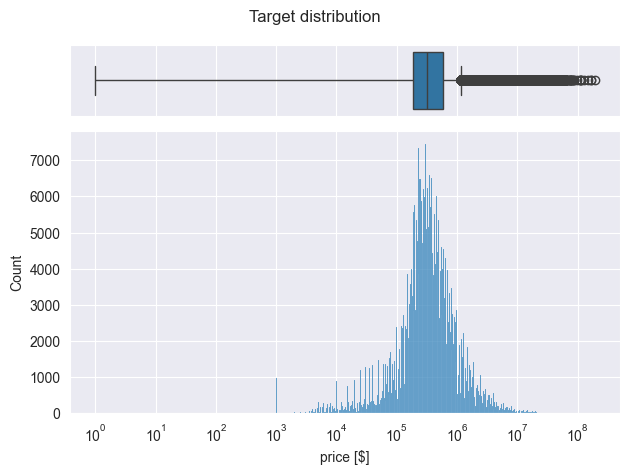

In [8]:
df['target'] = build_features.get_numerical_target(df['target'])

visualize.plot_box_hist_plot(
    df, 
    'target', 
    numeric_label='price [$]', 
    log_scale=True, 
    title='Target distribution',
);

График был построен в логарифмических координатах, так имеется большой разброс в стоимости жилья.
Больше половины объявлений имеют стоимость в диапазоне 100 000 - 1 000 000 $.
Расмотрим внимательнее выбросы.

In [9]:
display(HTML("<h2>Property type for low-cost"))
display(df[df['target'] < 1e5]['propertyType'].value_counts())
display(HTML("<h2>Property type for high-cost"))
display(df[df['target'] > 1e6]['propertyType'].value_counts())

propertyType
lot/land                10812
Land                     7304
single-family home       6581
Single Family            3285
Single Family Home       1967
                        ...  
Custom                      1
Multiplex, Ranch            1
English, Traditional        1
Other - See Remarks         1
Cottage/Camp                1
Name: count, Length: 166, dtype: int64

propertyType
single-family home                                                        9233
Single Family                                                             7099
condo                                                                     4286
Single Family Home                                                        2539
multi-family                                                              2437
                                                                          ... 
2 Stories, Traditional, Texas Hill Country                                   1
Single Detached, Contemporary/Modern, Other (See Remarks), Traditional       1
Courtyard, Custom                                                            1
Contemporary/Modern, English, French, Traditional                            1
Lake House, Single Detached, Tudor                                           1
Name: count, Length: 493, dtype: int64

В большиестве случаев низкая стоимость обусловлена тем, что продаётся земля.
Однако, есть подозрения, что в ряде случаев была указана стоимость аренды.
Последнее можно будет уточнить при последующем анализе данных.

Что же касается больших стоимостей, то по всей видимости речь идёт о дорогих особняках.
Их можно будет либо удалить как выбросы, либо делать прогноз в логарифмической шкале.
Уточним позже.

## sqft и stories

Разберёмся теперь с площадью и количеством этажей, так как они тоже должны иметь числовые признаки

In [10]:
display(df['sqft'].str.findall(r'[^0-9]+').value_counts())
display_html('<h2>Data with "--"', raw=True)
display(df[df['sqft'].str.contains('--', na=False)])
display_html('<h2>Data with "Total interior livable area"', raw=True)
display(df[df['sqft'].str.contains('Total interior livable area', na=False)])
display(
    df[
        df['sqft'].str.contains('Total interior livable area', na=False)
    ]['homeFacts'].iloc[0]
)

sqft
[,,  sqft]                                   138517
[,]                                           91482
[]                                            61588
[Total interior livable area: , ,,  sqft]     21077
[ sqft]                                       18434
[Total interior livable area: ,  sqft]         2266
[--]                                            535
[-- sqft]                                       276
[,, ,,  sqft]                                    18
[,, ,]                                            2
Name: count, dtype: int64

Data with "--"

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
440,For sale,NaN,Condo,606 W 81st St # 129 E,Bathrooms: 1,"{'atAGlanceFacts': [{'factValue': '1971', 'fac...",NaN,Hialeah,"[{'rating': ['10/10', '6/10', '6/10'], 'data':...",-- sqft,33014,1 bd,FL,NaN,A10773663,NaN,NaN,130000
700,NaN,NaN,Condo,1000 Brickell Ave # 2215,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Miami,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...",--,33131,2,FL,NaN,NaN,NaN,"2215, Miami, FL 33131",1100000
951,NaN,NaN,Multi Family,163 NW 68th Ter,4.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Miami,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...",--,33150,6,FL,2.0,NaN,NaN,A10741015,599000
1455,NaN,NaN,Townhouse,NW 89th Ter,3.0,"{'atAGlanceFacts': [{'factValue': '2015', 'fac...",NaN,Doral,"[{'rating': ['10/10', '8/10'], 'data': {'Dista...",--,33178,3,FL,NaN,NaN,Yes,A10732483,390000
2030,New construction,NaN,Single Family,3214 Walworth Ave,4.0,"{'atAGlanceFacts': [{'factValue': 'No Data', '...",Yes,Cincinnati,"[{'rating': ['2/10', '2/10'], 'data': {'Distan...",--,45226,3,OH,NaN,NaN,NaN,1614162,545000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374655,For sale,NaN,Condo,750 SW 138th Ave APT F205,2 ba,"{'atAGlanceFacts': [{'factValue': '1994', 'fac...",NaN,Pembroke Pines,"[{'rating': ['7/10', '8/10', '7/10'], 'data': ...",-- sqft,33027,2 bd,FL,NaN,A10776605,NaN,NaN,160000
375945,NaN,NaN,Townhouse,1433 SW 66th Ave,5.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,West Miami,"[{'rating': ['10/10', '3/10', '3/10'], 'data':...",--,33144,4,FL,NaN,NaN,NaN,A10765095,615000
376356,NaN,NaN,Condo,551 N Ftl Bch Blvd # H1016,2.0,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",NaN,Fort Lauderdale,"[{'rating': ['7/10', '5/10', '7/10'], 'data': ...",--,33304,1,FL,NaN,NaN,NaN,"H1016, Fort Lauderdale, FL 33304",897500
376988,NaN,NaN,Single Family,3435 East,1.0,"{'atAGlanceFacts': [{'factValue': '1955', 'fac...",NaN,Hialeah,"[{'rating': ['10/10', '3/10'], 'data': {'Dista...",--,33013,3,FL,NaN,NaN,NaN,A10783130,340000


Data with "Total interior livable area"

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
13,New construction,NaN,Single Family,1538 Umpqua Dr,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Eugene,"[{'rating': ['7/10', '7/10', '8/10'], 'data': ...","Total interior livable area: 1,820 sqft",97401,3 bd,OR,1.0,19221142,NaN,NaN,499900
21,For sale,NaN,Single Family,61425 Gosney Rd,Bathrooms: 5,"{'atAGlanceFacts': [{'factValue': '2008', 'fac...",Yes,Bend,"[{'rating': ['8/10', '5/10', '6/10'], 'data': ...","Total interior livable area: 5,266 sqft",97702,5 bd,OR,1.0,201909438,NaN,NaN,3500000
31,For sale,NaN,Single Family,6712 N Glen Ave,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '1960', 'fac...",NaN,Tampa,"[{'rating': ['5/10', '2/10', '4/10'], 'data': ...","Total interior livable area: 1,677 sqft",33614,4 bd,FL,0.0,T3159863,NaN,NaN,262000
38,For sale,NaN,Single Family,5531 Eureka Springs Rd,Bathrooms: 1,"{'atAGlanceFacts': [{'factValue': '1930', 'fac...",NaN,Tampa,"[{'rating': ['1/10', '2/10', '3/10'], 'data': ...","Total interior livable area: 1,232 sqft",33610,2 bd,FL,0.0,T3204536,NaN,NaN,117900
46,For sale,NaN,Single Family,4547 Cascades Shoreline Dr,Bathrooms: 5,"{'atAGlanceFacts': [{'factValue': '2005', 'fac...",Yes,Tyler,"[{'rating': ['4/10', '5/10', '2/10'], 'data': ...","Total interior livable area: 5,358 sqft",75709,5 bd,TX,2.0,10114247,NaN,NaN,1429000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377091,For sale,NaN,Single Family,916 Morningside Ln,Bathrooms: 3,"{'atAGlanceFacts': [{'factValue': '1993', 'fac...",Yes,Allen,"[{'rating': ['10/10', '10/10', '7/10'], 'data'...","Total interior livable area: 2,619 sqft",75002,4 bd,TX,2.0,14170825,NaN,NaN,319000
377093,For sale,NaN,Single Family,114 N 6th St,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '1905', 'fac...",NaN,Temple,"[{'rating': ['4/10', '4/10', '4/10'], 'data': ...","Total interior livable area: 1,361 sqft",76501,3 bd,TX,1.0,384383,NaN,NaN,129000
377112,For sale,Yes,Single Family,1906 W Workman Ave,Bathrooms: 3,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,West Covina,"[{'rating': ['6/10', '6/10', '7/10'], 'data': ...","Total interior livable area: 1,557 sqft",91790,4 bd,CA,1.0,CV19260192,NaN,NaN,639000
377113,For sale,NaN,Single Family,17617 W 87th Ave,Bathrooms: 4,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",NaN,Arvada,"[{'rating': ['7/10', '6/10', '8/10'], 'data': ...","Total interior livable area: 4,615 sqft",80007,4 bd,CO,2.0,7690588,NaN,NaN,685000


"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '2019', 'factLabel': 'Remodeled year'}, {'factValue': 'Forced air', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': 'Attached Garage', 'factLabel': 'Parking'}, {'factValue': '7,000 sqft lot', 'factLabel': 'lotsize'}, {'factValue': '$275', 'factLabel': 'Price/sqft'}]}"

"--" обозначают пропуски, их приведём к пропускам явно.
Также зачастую явно указывают "sqft", можем удалить, как и запятые.
Что касается пометки "total interior livable area", то помимо этой площади в `homeFacts` указазан "lotsize".
Чтобы не потерять на данном этапе сведений, добавим пока двоичный признак `marked_interior_area`

marked_interior_area
False    350963
True      23343
Name: count, dtype: int64

Доля объявлений с явно указанной внутренней жилой площадью: 6.236%
Доля пропусков площади: 10.933%


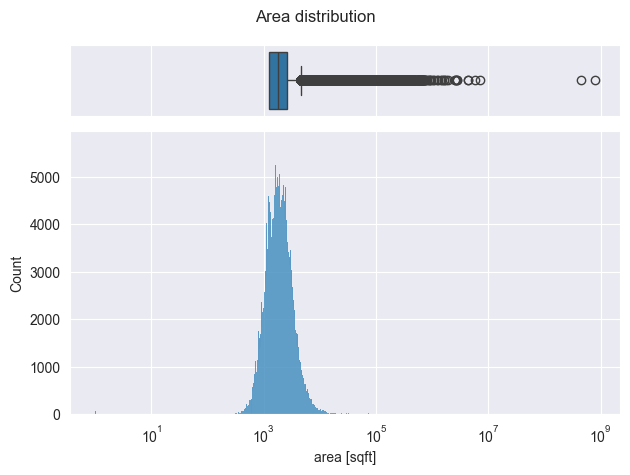

In [11]:
df = build_features.get_df_with_numerical_sqft(df)
display(df['marked_interior_area'].value_counts())
print(
    'Доля объявлений с явно указанной внутренней жилой площадью:', 
    utils.get_percentage(df['marked_interior_area'].sum(), df.shape[0])
)
print(
    'Доля пропусков площади:', 
    utils.get_percentage(df['sqft'].isna().sum(), df.shape[0])
)

visualize.plot_box_hist_plot(
    df, 
    'sqft', 
    numeric_label='area [sqft]', 
    log_scale=True, 
    title='Area distribution',
);

Видим также большой разброс в площади.
В основном, площадь больше 1000 квадратных футов, или 93 $м^2$

Есть также слишком большие особняки:

In [12]:
df[df['sqft']>1e7]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,marked_interior_area
62736,for sale,NaN,single-family home,1723 Pulte St,2 Baths,"{'atAGlanceFacts': [{'factValue': '1901', 'fac...",yes,Cincinnati,"[{'rating': ['4/10', '2/10', '1/10', '2/10', '...",795979430.0,45225,2 Beds,OH,1.0,NaN,NaN,1230095,27500,False
376529,Active,NaN,Multi-Family Home,5382 S Dixie Hwy,NaN,"{'atAGlanceFacts': [{'factValue': '2012', 'fac...",NaN,Glendale,"[{'rating': ['5', '7', '7', 'NR', 'NR', 'NR'],...",456602479.0,42740,NaN,KY,NaN,NaN,NaN,10050634,198000,False


При этом цена на них средняя (см выбросы больше $10^7$):

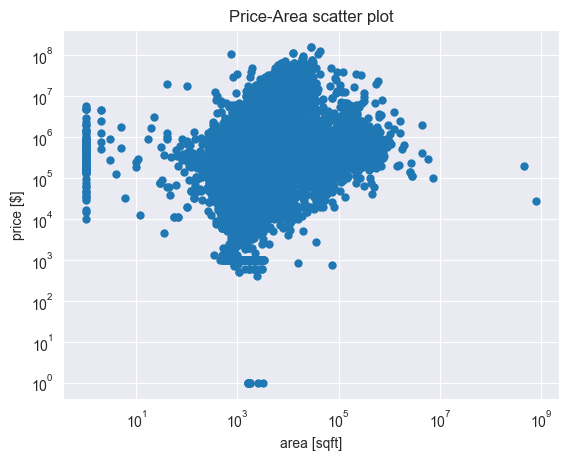

In [13]:
visualize.plot_scatter(
    data=df,
    x='sqft',
    y='target',
    logx=True,
    logy=True,
    x_label='area [sqft]',
    y_label='price [$]',
    title='Price-Area scatter plot',
    linewidth=0,
);

Впоследствии, можно удалить явные выбросы.
Также, возможно имеет смысл логарифмировать площадь.

### stories

Рассмотрим символы и встречающиеся варианты, предварительно переведя всё в lower:

In [14]:
df['stories'] = df['stories'].str.lower()
display(df['stories'].str.findall(r'[^0-9]+').value_counts().head(20))
display_html('<h2>Stories numbers', raw=True)
display(df['stories'].str.findall(r'[0-9]+').value_counts().head(30))
display_html('<h2>Stories contain "ground", "one", "two" or "three"', raw=True)
display(
    df[
        df['stories'].str.contains('ground', na=False) |
        df['stories'].str.contains('one', na=False) |
        df['stories'].str.contains('two', na=False) |
        df['stories'].str.contains('three', na=False)
    ]['stories'].value_counts()
)
display_list = ['split', 'story', 'level', 'lot']
for word in display_list:
    display_html(f'<h2>Stories contain "{word}"', raw=True)
    display(
        df[
            df['stories'].str.contains(word, na=False)
        ]['stories'].value_counts()
    )

display_html(f'<h2>Property type of Stories with zeros', raw=True)
display(
    df[
        df['stories'].isin(['0', '0.0'])
    ]['propertyType'].value_counts()
)

stories
[.]                     154467
[]                       51919
[one]                     5758
[ story]                  3470
[two]                     2495
[+]                        868
[three or more]            569
[one story]                395
[ level, site built]       380
[lot]                      365
[townhouse]                325
[ranch/,  story]           293
[multi/split]              271
[ level]                   268
[two story or more]        253
[ stories]                 243
[acreage]                  215
[.,  story]                203
[condominium]              172
[ story/basement]          161
Name: count, dtype: int64

Stories numbers

stories
[1, 0]       66808
[2, 0]       55003
[1]          24820
[2]          20776
[]           12074
[3, 0]       11233
[0, 0]        7209
[3]           5358
[0]           4231
[9, 0]        2914
[2, 00]       2775
[4, 0]        2136
[1, 00]       1200
[4]            933
[6, 0]         716
[1, 50]        650
[5, 0]         614
[1, 5]         566
[3, 00]        517
[9]            467
[7, 0]         312
[6]            291
[8, 0]         254
[2, 0000]      229
[5]            189
[1, 0000]      116
[2, 5]          97
[12, 0]         94
[2, 50]         92
[7]             92
Name: count, dtype: int64

Stories contain "ground", "one", "two" or "three"

stories
one                                5758
two                                2495
three or more                       569
one story                           395
two story or more                   253
one level                           142
one and one half                     25
three or more levels                 25
one, two                             13
three or more, multi/split            7
ground level                          6
two stories                           4
ground level, one                     3
two, multi/split                      3
one, three or more                    3
multi/split, two                      1
ground level, split level, two        1
ground level, two                     1
one, two, multi/split                 1
two, three or more                    1
other, two, multi/split               1
multi level, three or more            1
one and one half, three or more       1
Name: count, dtype: int64

Stories contain "split"

stories
multi/split                         271
split level                          52
split foyer                          14
site built, split foyer               9
split level w/ sub                    8
three or more, multi/split            7
two, multi/split                      3
site built, split level               3
2 story, split level                  2
3 level, site built, split level      1
ground level, split level, two        1
multi/split, two                      1
2 level, site built, split foyer      1
split foyer, tri-level                1
other, two, multi/split               1
bedroom - split plan                  1
1 story, split level                  1
2 level, split foyer                  1
split entry (bi-level)                1
one, two, multi/split                 1
1 level, split foyer                  1
Name: count, dtype: int64

Stories contain "story"

stories
2 story                                       1970
1 story                                       1253
one story                                      395
ranch/1 story                                  293
two story or more                              253
3 story                                        204
1.5 story                                      169
2 story/basement                               154
1 story basement                                82
4 story                                         43
1 story/ranch                                   40
2.5 story                                       34
1.5 story/basement                              33
1 story/f.r.o.g.                                13
3 story/basement                                 7
3+ story                                         4
multi-story                                      3
2 story, tri level                               2
1 story, 2 story                                 2
2 story, split level   

Stories contain "level"

stories
2 level, site built               192
1 level, site built               155
1 level                           148
one level                         142
stories/levels                    133
                                 ... 
3 story, tri level                  1
multi level, three or more          1
3 story, multi level                1
split entry (bi-level)              1
3 level, site built, tri-level      1
Name: count, Length: 62, dtype: int64

Stories contain "lot"

stories
lot    365
Name: count, dtype: int64

Property type of Stories with zeros

propertyType
Single Family            7639
Condo                    2141
Townhouse                 768
Multi Family              416
Mobile / Manufactured     402
Cooperative                50
Apartment                  19
SingleFamilyResidence       3
Name: count, dtype: int64

- "one", "two", "three" можно заменить на числовые эквиваленты.
- "ground" можно заменить на 1.

Также:
- "split", "tri", "multi" предполагают больше, чем 1 этаж. Можно положить равенство 1.5. Но решение принимается ниже.
- Нулевые значения можно рассматривать как отсутствие этих значений, так как среди `propertyType` отсутствует Land.
- "lot" можно рассматривать как ноль этажей - продаётся земельный участок.
- Есть также количества этажей больше 3 (даже 8, 9 и больше). Требуется проверить потом

Будем создавать отдельный признак для последующей проверки

Для начала, заменим на числовые значения. И проанализируем кейсы без чисел вообще

In [15]:
df['stories'] = build_features.replace(
    df['stories'],
    replace_map=(
        ('ground', '1'),
        ('one', '1'),
        ('two', '2'),
        ('three', '3'),
    )
)
# Get stories sorted by count of appearance
no_num_stories = df[
    ~df['stories'].str.contains(r'[0-9]+', na=False)
]['stories'].value_counts().head(9)

# Display propertyTypes for popular no-number stories
for value in no_num_stories.index:
    display_html(f'<h3>{value}', raw=True)
    display(df[df['stories'] == value]['propertyType'].value_counts())

lot

propertyType
Land    365
Name: count, dtype: int64

townhouse

propertyType
Condo/Townhome/Row Home/Co-Op    325
Name: count, dtype: int64

multi/split

propertyType
Split-Level                               110
High Rise, Split-Level                     38
Cluster Home, Split-Level                  11
Garden Home, Split-Level                   10
Condo/Townhome/Row Home/Co-Op              10
Detached, Two Story, Split-Level            9
Detached, One Story, Split-Level            7
Single Family Home                          6
Detached, Split-Level                       6
Two Story, Split-Level                      5
Penthouse, Split-Level                      5
One Story, Split-Level                      4
Traditional                                 3
Multi-Family Home                           3
Bi-Level, Split-Level                       2
Bungalow                                    2
Custom                                      2
Cluster Home, Garden Home, Split-Level      2
Contemporary                                2
Florida                                     2
Colonial, Split-Level                       2
Spanish/Mediterranean

acreage

propertyType
Land    215
Name: count, dtype: int64

condominium

propertyType
Condo/Townhome/Row Home/Co-Op    172
Name: count, dtype: int64

stories/levels

propertyType
Single Family Home               95
Condo/Townhome/Row Home/Co-Op    38
Name: count, dtype: int64

ranch

propertyType
Single Family Home               120
Condo/Townhome/Row Home/Co-Op      7
Name: count, dtype: int64

traditional

propertyType
Single Family Home    88
Name: count, dtype: int64

mid-rise

propertyType
Condo/Townhome/Row Home/Co-Op    78
Name: count, dtype: int64

Примем:
- "lot" и "acreage" можно выставить 0
- "ranch" и "traditional"  - 1 этаж
- "multi/split", "stories/levels" - встречаются разные типы и количества этажей в `propertyType`. 
Сходу сложно определить этаж.
Возможно, стоит установить None, но поставим пока 1.5
- "townhouse" - как правило 2, макс. 3 этажа. Причём для townhouse в дальнейшем можно было ввести уточнение в `propertyType`
- "condominium", "mid-rise" - 3 и более этажей.

Заполним численные значения в соответствии с рекомендациями выше:

count    213162.000000
mean          2.011041
std           4.341044
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max        1120.000000
Name: stories_num, dtype: float64

Доля объявлений с пропуском численного количества этажей: 43.051%


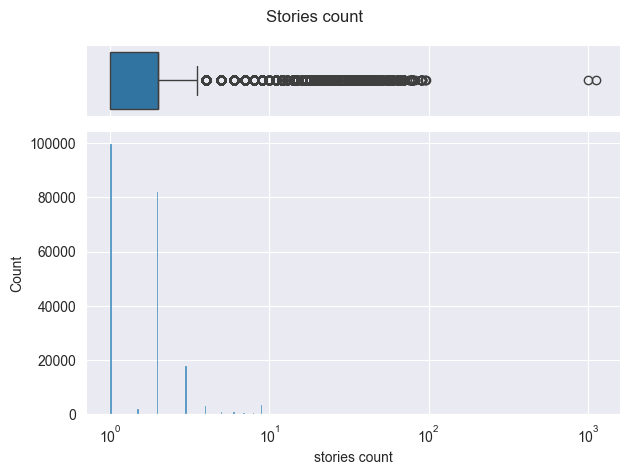

In [16]:
df = build_features.get_df_with_numerical_story(df)
display(df['stories_num'].describe())
print(
    'Доля объявлений с пропуском численного количества этажей:', 
    utils.get_percentage(df['stories_num'].isna().sum(), df.shape[0])
)

visualize.plot_box_hist_plot(
    df, 
    'stories_num', 
    numeric_label='stories count', 
    log_scale=True, 
    title='Stories count',
);

Несмотря на попытки заполнить это количество этажей, по-прежнему много пропусков.
Возможно, впоследствии удастся их заполнить, проанализировав `propertyType`

Есть выбросы, с которыми также необходимо будет разобраться!

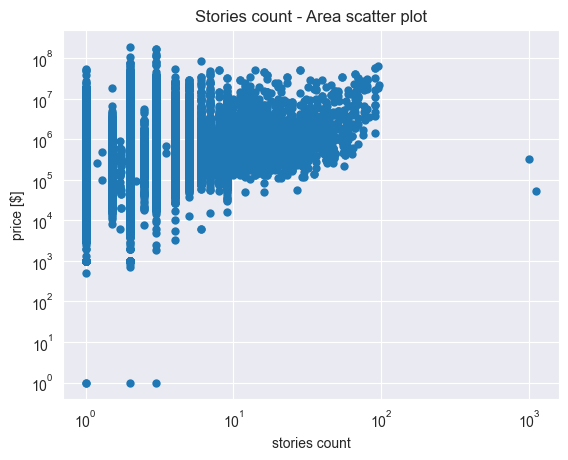

In [17]:
visualize.plot_scatter(
    data=df,
    x='stories_num',
    y='target',
    logx=True,
    logy=True,
    x_label='stories count',
    y_label='price [$]',
    title='Stories count - Area scatter plot',
    linewidth=0,
);

По нижней границе стоимости видим тенденцию к возрастанию

## baths и beds

Рассмотрим, как выглядят значения в категориях baths и beds

In [18]:
display(df['baths'].value_counts().head(50))
display(df['beds'].value_counts().head(50))

baths
2 Baths         51953
3 Baths         35356
2               20429
2.0             16355
4 Baths         14712
3.0             10797
3               10093
Bathrooms: 2     9411
2.5              8113
Bathrooms: 3     6569
1                6569
1.0              5799
5 Baths          5365
4.0              4559
2.5 Baths        4388
0                3811
4                3561
3.5              3455
Bathrooms: 1     3126
2 ba             2679
6 Baths          2599
Bathrooms: 4     2372
1,500            2207
3 ba             1884
1.5              1857
2,000            1792
3.5 Baths        1789
1,750            1720
3,000            1684
5.0              1551
2,250            1440
1,000            1279
5                1219
7 Baths          1208
1,250            1203
4.5              1016
2,750             964
2,500             894
Bathrooms: 5      823
~                 780
1 ba              747
4 ba              735
6.0               733
3,500             653
8 Baths           638
6   

beds
3 Beds        52947
4 Beds        35149
3             31191
2 Beds        26084
4             19915
2             15998
Baths         15258
3 bd          12678
5 Beds        11205
4 bd           8193
3.0            8085
5              6392
4.0            5231
2 bd           5166
1              4583
6 Beds         3784
5 bd           2619
2.0            2429
6              1792
5.0            1372
0              1208
7 Beds         1095
1 bd           1068
-- bd           845
8 Beds          754
Bath            737
6 bd            643
7               510
1.0             429
                350
9 Beds          345
8               316
6.0             311
0.0             223
10 Beds         175
7 bd            145
12 Beds         130
8 bd             94
9                94
-- sqft          94
5,000 sqft       90
11 Beds          84
7.0              67
10               66
1 acre           46
64 Beds          44
16 Beds          41
8.0              41
0.34 acres       39
0.28 acres     

Baths:
- Нередко, есть приписки типа "Baths", "Bathrooms"
- Есть пропуски, обозначенные "~" или "--"
- Также есть странные значения, типа "1,500", "1,750", "2,000" и так далее. 
Наличие нулевых значений после запятой не даёт возможности полагать, что это некая "суммарная площадь", если только это не обозначение пропуска в данных. 
Также, нереально предполагать, что это тысячи ванных комнат (нередко тип дома - частный жилой).

Посмотрим, что при этом указано в beds:

In [19]:
df[df['baths'].str.contains(',', na=False)]['beds'].value_counts()

beds
Baths    14056
Bath       209
             1
Name: count, dtype: int64

Видим, что при наличии запятой в выражении, идёт ссылка на "Bath", а также есть один пропуск.
Можем предположить, что речь идёт о паре "спальня с ванной".

Пожалуй, имеет смысл полагать дробное разделение

In [20]:
df[df['baths'].str.contains(',', na=False)][['propertyType', 'baths', 'beds', 'sqft', 'stories']].head(40)

,propertyType,baths,beds,sqft,stories
16,NaN,"1,750",Baths,2203.0,NaN
22,"Penthouse, Split-Level","1,000",Baths,1080.0,multi/split
26,NaN,"1,000",Baths,NaN,NaN
115,"1 Story, Ranch","2,500",Baths,1470.0,NaN
182,"1 Story, Traditional","4,000",Baths,3097.0,NaN
207,NaN,"2,000",Baths,NaN,NaN
210,NaN,"3,000",Baths,3671.0,NaN
328,NaN,"2,000",Baths,2050.0,NaN
332,NaN,"1,500",Baths,1544.0,NaN
341,"Contemporary/Modern, Traditional","1,250",Baths,3004.0,3


Сопоставим площади, когда есть acres в Beds:

In [21]:
raw_df[raw_df['beds'].str.contains('acre', na=False)]['sqft'].value_counts(dropna=False)

sqft
NaN           1628
-- sqft         11
1,844 sqft       1
Name: count, dtype: int64

Видим, что в большинстве случаев данные по площади попросту отсутствуют, поэтому положим значение None для значения acres.

### Последовательность обработки признаков baths и beds:

Baths:
- Заполнить None-ами строки, содержащие "--", "~", пустые строки после удаления лишних пробелов
- Заменить запятые на точки
- Извлечь числовые значения (в общем случае, с плавающей точкой), а при отсутствии таковых - None

Beds:
- Заполнить None-ами строки, содержащие "--", "~", пустые строки после удаления лишних пробелов
- Заполнить None-ами строки, содержащие "acre", "sqft"
- Извлечь числовые значения (в общем случае, с плавающей точкой), а при отсутствии таковых - None

In [22]:
df['baths'].isna().sum()

105288

In [23]:
build_features.convert_to_none(df['baths'], ('--', '~', '')).isna().sum()

106563

In [24]:
df['beds'].isna().sum()

90909

In [28]:
build_features.convert_to_none(df['beds'], ('--', '~', '', 'acre', 'sqft')).isna().sum()

95078

# Draft

In [ ]:

# visualize.plot_boxplot(
#     df, 
#     'target', 
#     title='Target boxplot', 
#     numeric_label='price, $', 
#     log_scale=True    
# );

In [40]:
res = df['homeFacts'][1].replace('\'', '"').replace('None', '""')
res[285:290]

'l": "'

In [41]:
res

'{"atAGlanceFacts": [{"factValue": "2019", "factLabel": "Year built"}, {"factValue": "", "factLabel": "Remodeled year"}, {"factValue": "", "factLabel": "Heating"}, {"factValue": "", "factLabel": "Cooling"}, {"factValue": "", "factLabel": "Parking"}, {"factValue": "5828 sqft", "factLabel": "lotsize"}, {"factValue": "$159/sqft", "factLabel": "Price/sqft"}]}'

In [44]:
import json
facts_dt = json.loads(res)
facts_dt

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'},
  {'factValue': '', 'factLabel': 'Remodeled year'},
  {'factValue': '', 'factLabel': 'Heating'},
  {'factValue': '', 'factLabel': 'Cooling'},
  {'factValue': '', 'factLabel': 'Parking'},
  {'factValue': '5828 sqft', 'factLabel': 'lotsize'},
  {'factValue': '$159/sqft', 'factLabel': 'Price/sqft'}]}

In [45]:
facts_dt['atAGlanceFacts']

[{'factValue': '2019', 'factLabel': 'Year built'},
 {'factValue': '', 'factLabel': 'Remodeled year'},
 {'factValue': '', 'factLabel': 'Heating'},
 {'factValue': '', 'factLabel': 'Cooling'},
 {'factValue': '', 'factLabel': 'Parking'},
 {'factValue': '5828 sqft', 'factLabel': 'lotsize'},
 {'factValue': '$159/sqft', 'factLabel': 'Price/sqft'}]

In [47]:
df['mls-id'].value_counts()

mls-id
No MLS#      3
No           3
1498550      2
39888954     2
608063       2
            ..
1020314      1
A10762436    1
1592770      1
14201834     1
F10202858    1
Name: count, Length: 24907, dtype: int64

In [48]:
df['MlsId'].value_counts()

MlsId
NO MLS                     24
No MLS #                   16
 A, Houston, TX 77008      13
 12A, Orlando, FL 32833    11
 B, Houston, TX 77008       9
                           ..
19092240                    1
RX-10563061                 1
218080001                   1
14154778                    1
10374233                    1
Name: count, Length: 232944, dtype: int64

In [121]:
df[df['MlsId'].str.lower().str.contains(r'no[^a-zA-Z0-9,](mls)*', na=False)]['MlsId'].value_counts()

/var/folders/dv/7ymr80q90cs45p34fgkdmj0c0000gn/T/ipykernel_91802/3364708247.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[df['MlsId'].str.lower().str.contains(r'no[^a-zA-Z0-9,](mls)*', na=False)]['MlsId'].value_counts()


MlsId
NO MLS                                      24
No MLS #                                    16
No                                           9
No mls                                       8
No MLS                                       6
No MLS                                       2
0087, Solano at Altair, Irvine, CA 92618     1
0061, Solano at Altair, Irvine, CA 92618     1
No  MLs #                                    1
Name: count, dtype: int64

In [88]:
df[df['MlsId'].str.lower().str.contains(r'no(\W*)(mls)|(no)^[A-Za-z]', na=False)]['MlsId'].value_counts()

/var/folders/dv/7ymr80q90cs45p34fgkdmj0c0000gn/T/ipykernel_91802/2669860384.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[df['MlsId'].str.lower().str.contains(r'no(\W*)(mls)|(no)^[A-Za-z]', na=False)]['MlsId'].value_counts()


MlsId
NO MLS       24
No MLS #     16
No mls        8
No MLS        6
NOMLSID       6
No MLS        2
No  MLs #     1
Name: count, dtype: int64

In [96]:
df[df['MlsId'].str.lower().str.contains('no', na=False)]['MlsId']

2348               1401, North Miami, FL 33181
6720                                       No 
8196                                    No MLS
8610                                       No 
9028                                    No MLS
                          ...                 
364310                      16, Reno, NV 89523
366774     17208W, North Miami Beach, FL 33162
367932                                     No 
370434             2207, North Miami, FL 33181
372018        301, North Bay Village, FL 33141
Name: MlsId, Length: 161, dtype: object

In [102]:
df[df['MlsId'].isin(['no'])]['MlsId']

Series([], Name: MlsId, dtype: object)

In [116]:
df[df['MlsId'].str.lower().str.strip().isin(['no'])]['MlsId']

6720      No 
8610      No 
44792     No 
132144    No 
207894    No 
223985    No 
326882    No 
344235    No 
367932    No 
Name: MlsId, dtype: object